## Restore the variables from the last session

In [2]:
store -r

Unable to restore variable 'credit_df', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


## What is Autoencoder?
Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.
Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.
Here is an example of the input/output image from the MNIST dataset to an autoencoder.


<img src="./images/autoencoder.png">


### Autoencoders consists of 4 main parts:
1- **Encoder**: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2- **Bottleneck**: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data.

3- **Decoder**: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4- **Reconstruction Loss**: This is the method that measures measure how well the decoder is performing and how close the output is to the original input.

## Why Autoencoder works for Anomaly Detection?
Autoencoders are great in learning what is normal. I can identify the normal region ina distribution then anything that is considered an outlier will return a high reconstruction error.

Let's start by installing some pre-requisite libraries. H2O is an open-source library that can be used to do a number of machine learning tasks. It has a function for the autoencoders. Let's have a look

In [3]:
!pip install h2o

You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Importing necessary libraries

In [4]:
import h2o
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

## Starting and initializing H2O server.

In [5]:
h2o.init(max_mem_size = 2) # initializing h2o server
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7_91cm7_
  JVM stdout: /tmp/tmp7_91cm7_/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmp7_91cm7_/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_ec2_user_3xdovb
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


## Loading the dataset into a H2O dataframe and splitting the DS.

In [6]:
creditData_df = h2o.import_file(r"data/creditcard.csv") 
features= creditData_df.drop(['Time'], axis=1)
train, test = features.split_frame([0.8])

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Preprocess the dataset

In [7]:
# converting to pandas dataframe
train_df = train.as_data_frame()
test_df = test.as_data_frame()

train_df = train_df[train_df['Class'] == 0]
fraud_df = train_df[train_df['Class'] == 1]

# drop the Class variable
train_df = train_df.drop(['Class'], axis=1)
Y_test_df = test_df['Class'] # true labels of the testing set
test_df = test_df.drop(['Class'], axis=1)

# converting to h2o frame
train_h2o = h2o.H2OFrame(train_df) 
test_h2o = h2o.H2OFrame(test_df)
train_cols = train_h2o.columns

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Create a local estimator and start the training process

In [8]:
anomaly_model = H2ODeepLearningEstimator(activation = "Tanh",
                               hidden = [14,7,7,14],
                               epochs = 100,
                               standardize = True,
                                stopping_metric = 'MSE', 
                                loss = 'automatic',
                                train_samples_per_iteration = 32,
                                shuffle_training_data = True,     
                               autoencoder = True,
                               l1 = 10e-5)
anomaly_model.train(x=train_cols, training_frame = train_h2o)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


## Show the model feature importance in a dataframe

In [9]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,V13,1.000000,1.000000,0.152788
1,V15,0.985502,0.985502,0.150573
2,V24,0.942055,0.942055,0.143935
3,V26,0.906310,0.906310,0.138474
4,V18,0.900125,0.900125,0.137529
5,V11,0.892266,0.892266,0.136328
6,V19,0.881232,0.881232,0.134642
7,V4,0.007729,0.007729,0.001181
8,V16,0.004978,0.004978,0.000761
9,V9,0.004813,0.004813,0.000735


## Visualization of the feature importance

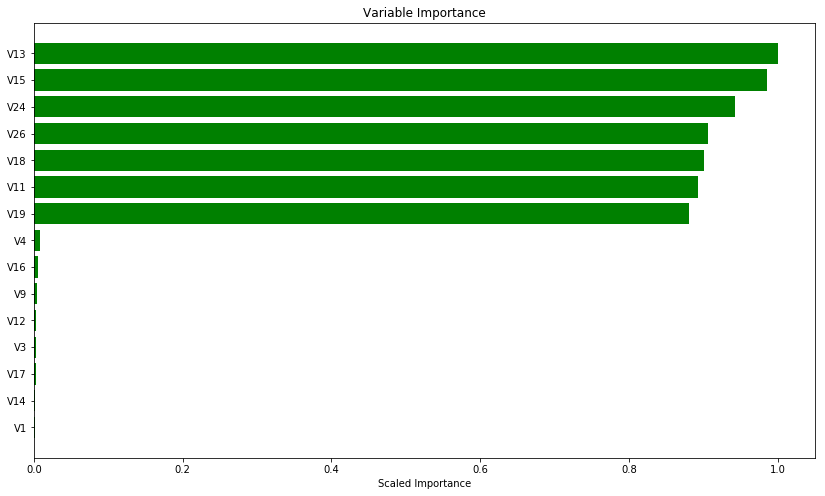

In [10]:
# plotting the variable importance
rcParams['figure.figsize'] = 14, 8
#plt.rcdefaults()
fig, ax = plt.subplots()

variables = anomaly_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:15]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

## Visualize the model lose

Text(0.5, 0, 'epoch')

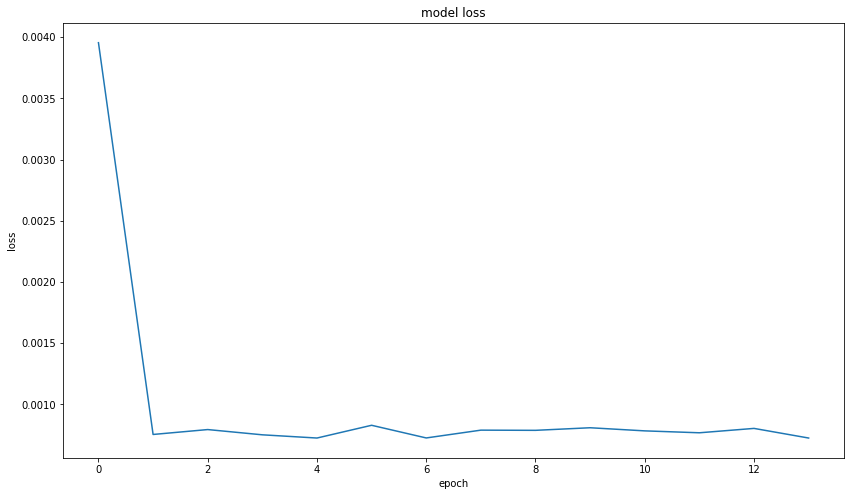

In [11]:
# plotting the loss
scoring_history = anomaly_model.score_history()
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

## Visualize the scatter plot across the dataset

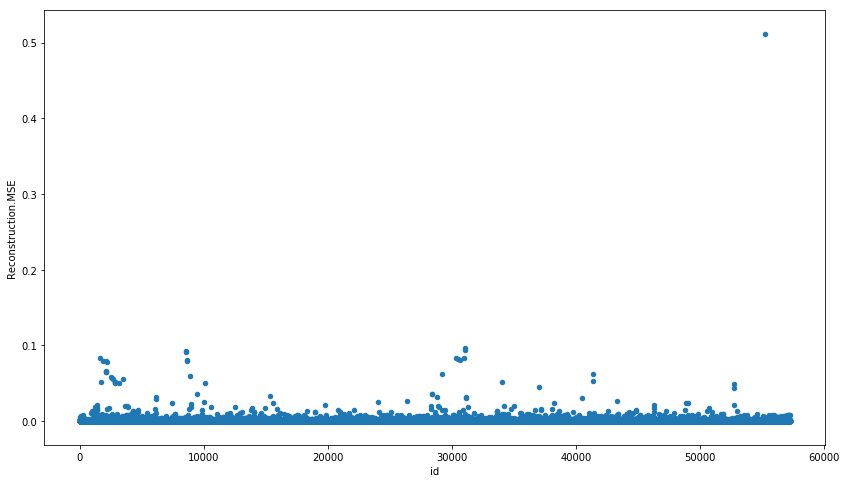

In [12]:
test_rec_error = anomaly_model.anomaly(test_h2o) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

In [20]:
# predicting the class for the testing dataset
predictions = anomaly_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.groupby('true_class').count()

deeplearning prediction progress: |███████████████████████████████████████| 100%


,reconstruction_error
true_class,
0,57120
1,100


## Calculate the threshold score/ cutoff score

In [27]:
score_mean = error_df['reconstruction_error'].mean()
score_std = error_df['reconstruction_error'].std()
score_cutoff = score_mean + 4*score_std
score_cutoff

0.012424082716339331

In [22]:
error_df[(error_df['true_class'] == 1) & error_df['reconstruction_error'] > 0.0095].count()

reconstruction_error    100
true_class              100
dtype: int64

## Print out the confusion matrix

Adjust and tune the confusion matrix from the threshold.

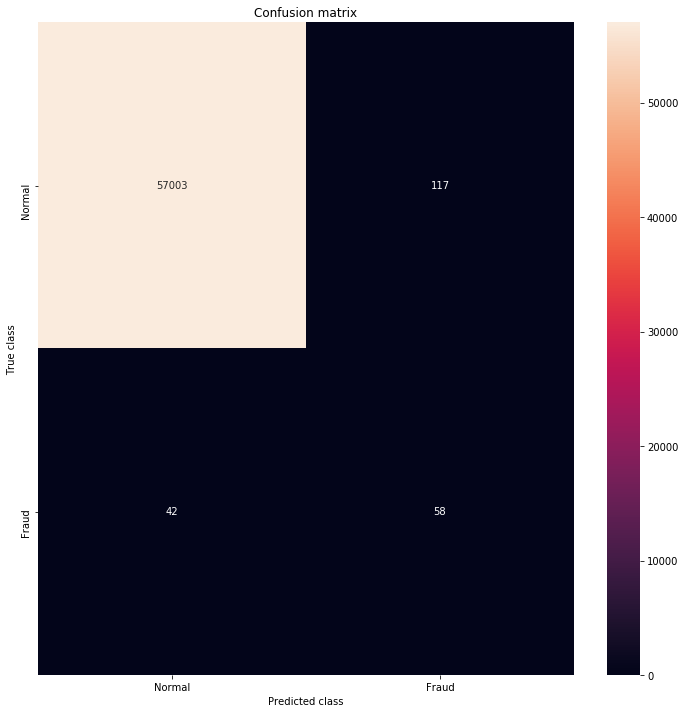

In [30]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
threshold = 0.009
LABELS = ['Normal', 'Fraud']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()